**PREDICTING PCOS IN CASES WITHOUT INFERTILITY**

**USING LOGISTIC REGRESSION**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [21]:
from google.colab import drive
drive.mount('/content/drive')
file_path = r"/content/drive/MyDrive/PCOS_data_without_infertility.xlsx"
data = pd.read_excel(file_path , sheet_name="Full_new")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Display basic information about the dataset
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN


In [24]:
# Drop columns that are not needed for the analysis
data = data.drop(["Sl. No", "Patient File No."], axis=1)

In [25]:
# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

In [26]:
# Encode categorical variables
categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

In [27]:
data.columns

Index(['PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)', 'Height(Cm) ', 'BMI',
       'Blood Group', 'Pulse rate(bpm) ', 'RR (breaths/min)', 'Hb(g/dl)',
       'Cycle(R/I)', 'Cycle length(days)', 'Marraige Status (Yrs)',
       'Pregnant(Y/N)', 'No. of aborptions', '  I   beta-HCG(mIU/mL)',
       'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH',
       'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio', 'TSH (mIU/L)',
       'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)',
       'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)',
       'Unnamed: 44'],
      dtype='object')

In [28]:
# Define features and target
X = data.drop('PCOS (Y/N)', axis=1)
y = data['PCOS (Y/N)']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [29]:
# Feature selection using RandomForest Importance
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_resampled, y_resampled)
feature_importance = pd.Series(rf_temp.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = feature_importance[:10].index  # Selecting top 10 features
X_resampled = X_resampled[top_features]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**LOGISTIC REGRESSION MODEL **

In [12]:
# Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

**SVM **

In [15]:
# Support Vector Machine with Hyperparameter Tuning
svm = SVC()
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=skf, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)

**RANDOM FOREST**

In [16]:
# Random Forest with Hyperparameter Tuning
rf = RandomForestClassifier()
param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15], 'min_samples_split': [5, 10]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=skf, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

**ENSEMBLE LEARNING **

In [17]:
# Ensemble Learning (Voting Classifier)
ensemble_model = VotingClassifier(estimators=[('log_reg', log_reg), ('svm', best_svm), ('rf', best_rf)], voting='hard')
ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)

In [18]:
# Model Evaluation
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred))
    return acc

acc_log = evaluate_model("Logistic Regression", y_test, y_pred_log)
acc_svm = evaluate_model("SVM", y_test, y_pred_svm)
acc_rf = evaluate_model("Random Forest", y_test, y_pred_rf)
acc_ensemble = evaluate_model("Ensemble Model", y_test, y_pred_ensemble)

Logistic Regression Accuracy: 0.9247
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        73
           1       0.91      0.95      0.93        73

    accuracy                           0.92       146
   macro avg       0.93      0.92      0.92       146
weighted avg       0.93      0.92      0.92       146

SVM Accuracy: 0.9521
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        73
           1       0.97      0.93      0.95        73

    accuracy                           0.95       146
   macro avg       0.95      0.95      0.95       146
weighted avg       0.95      0.95      0.95       146

Random Forest Accuracy: 0.9658
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        73
           1       0.97      0.96      0.97        73

    accuracy                           0.97       146
   macro avg       0.97      0.97      

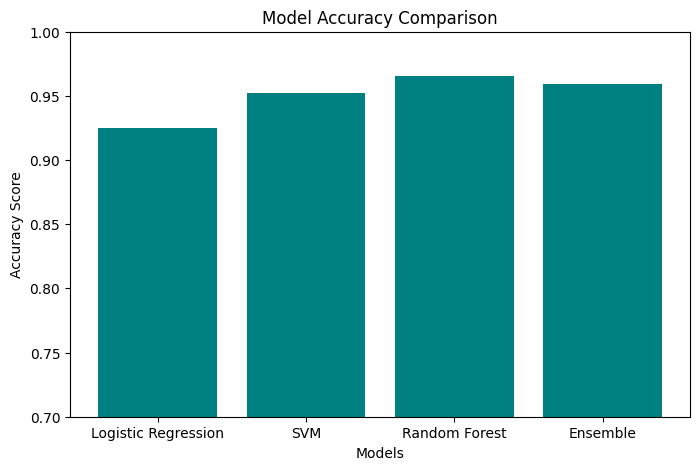

In [19]:

# Plot Model Accuracy
models = ['Logistic Regression', 'SVM', 'Random Forest', 'Ensemble']
accuracy_scores = [acc_log, acc_svm, acc_rf, acc_ensemble]
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracy_scores, color='teal')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.title('Model Accuracy Comparison')
plt.ylim(0.7, 1)
plt.show()